# Part 4: Modeling Content-based Filtering with DecisionTreeClassifier and Tfidf
---
- Importing the relevant libraries first...

In [1]:
#import requests
import random
#import time
import numpy as np
import pandas as pd
#from bs4 import BeautifulSoup as bs
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import joblib

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/jasonchia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## Importing X_legit and y which contain the shops that userid 2043 rated and ratings respectively
---

In [2]:
X_legit = pd.read_csv('yelp_data/xlegit.csv')
X_legit.shape

(980, 19307)

In [3]:
y = pd.read_csv('yelp_data/y.csv', squeeze=True)
y.head()

0    4.0
1    4.0
2    5.0
3    5.0
4    4.0
Name: user_rating, dtype: float64

In [4]:
#split the dataset into train and test sets first
X_train, X_test, y_train, y_test = train_test_split(X_legit, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
y_train.value_counts(normalize=True)

4.0    0.479592
5.0    0.383929
3.0    0.118622
2.0    0.012755
1.0    0.005102
Name: user_rating, dtype: float64

<ul>
    
- The baseline accuracy will be 0.48 since that is the highest proportion among the training dataset's target classes

In [6]:
#instantiate scaler since not all of the features are of the same scale, eg. review_count and avg_store_rating
ss = StandardScaler()

In [7]:
#fitting the train and transforming both the train and test sets
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [8]:
#getting a rough sense of the performance of the decisiontreeclassifier
#cross_val_score(DecisionTreeClassifier(),X_train_sc,y_train,cv=10).mean()

<ul>
    
- ```cross_val_score``` was 0.79!

In [9]:
#this is for tuning decisiontreeclassifier
#params = {
#    'max_depth':[3,5,7,10],
#    'min_samples_split':[5, 10, 15, 20],
#    'min_samples_leaf':[2, 3, 4, 5, 6, 7],
#    'class_weight':['balanced']
#    } 


#dtc_gridsearch = GridSearchCV(DecisionTreeClassifier(), params, cv = 10, verbose = 1, n_jobs = -1)
#dtc_gridsearch.fit(X_train_sc, y_train)

In [10]:
#loading a tuned decisiontreeclassifier from before (cell above)
loaded_model = joblib.load('yelp_data/dtc_gs_model.sav')

In [11]:
#tuned decisiontreeclassifier apparently performed better
loaded_model.best_estimator_.score(X_test_sc,y_test)

0.8469387755102041

<ul>
    
- Accuracy is 0.85!

In [12]:
#tuned decisiontreeclassifier's params
loaded_model.best_params_

{'class_weight': 'balanced',
 'max_depth': 7,
 'min_samples_leaf': 4,
 'min_samples_split': 15}

## Formulating recommendations for userid 2043 based on DecisionTreeClassifier model
---

In [13]:
#stacking X_test as first step in regenerating the shops column for predictions
trial = X_test.stack()

In [14]:
#creating loop to re-generate original X_test order of shops
index_lst = []
outlets_lst = []
for n in range(len(trial.index)):
    if trial.index[n][1].startswith('shops_') and trial[n]!=0:
        index_lst.append(str(trial.index[n][0]))
        outlets_lst.append(trial.index[n][1])
index_lst = [int(x) for x in index_lst]
reconstructed_X_test = pd.DataFrame({'shops':outlets_lst}, index=index_lst)

In [15]:
#checking out the reconstructed df
reconstructed_X_test.head()

,shops
292,shops_got-luck-cafe-singapore
748,shops_symmetry-singapore
780,shops_the-bread-project-singapore
213,shops_dean-and-deluca-singapore-4
689,shops_stack-singapore


In [16]:
#creating column of rating predictions
rating_predictions = loaded_model.best_estimator_.predict(X_test_sc)

In [17]:
#adding column of rating predictions into reconstructed df
reconstructed_X_test['predicted_ratings']=rating_predictions

In [18]:
#checking the reconstructed df out after including the rating predictions' column...
reconstructed_X_test.head()

,shops,predicted_ratings
292,shops_got-luck-cafe-singapore,4.0
748,shops_symmetry-singapore,4.0
780,shops_the-bread-project-singapore,4.0
213,shops_dean-and-deluca-singapore-4,4.0
689,shops_stack-singapore,3.0


In [19]:
#adding the actual ratings into the reconstructed df for comparison later on...
reconstructed_X_test['actual_ratings']=y_test

In [20]:
#top 5 recommendations for userid 2043 based on content-based filtering (using decision tree classifier) predictions
reconstructed_X_test.sort_values('predicted_ratings', ascending=False).head(5)

,shops,predicted_ratings,actual_ratings
477,shops_meidi-ya-singapore-2,5.0,5.0
630,shops_rayz-bistro-singapore,5.0,5.0
605,shops_plus-eight-two-singapore,5.0,5.0
908,shops_two-blur-guys-singapore,5.0,4.0
662,shops_shen-and-co-singapore,5.0,5.0


In [21]:
#saving this reconstructed_X_test fusion with collab X_test to evaluate hybrid system later on. 
reconstructed_X_test.to_csv('yelp_data/userid2043_cb_pred_actual.csv',index=False)

## Defining functions for evaluation of model
---

In [22]:
#defining function for obtaining tn, fp, fn, tp for each rating class for feeding into micro-avg precision and recall functions defined below
def cm_spec(y_true,y_pred,rating,state):
    if state=='tn':
        return multilabel_confusion_matrix(y_true,y_pred)[rating-1][0][0]
    elif state=='fp':
        return multilabel_confusion_matrix(y_true,y_pred)[rating-1][0][1]
    elif state=='fn':
        return multilabel_confusion_matrix(y_true,y_pred)[rating-1][1][0]
    else:
        return multilabel_confusion_matrix(y_true,y_pred)[rating-1][1][1]
    

In [23]:
#defining function for obtaining micro-avg precision
def micro_avg_precision(y_true,y_pred):
    return ((cm_spec(y_true,y_pred,1,'tp')+
                                                 cm_spec(y_true,y_pred,2,'tp')+
                                                 cm_spec(y_true,y_pred,3,'tp')+
                                                 cm_spec(y_true,y_pred,4,'tp')+
                                                 cm_spec(y_true,y_pred,5,'tp'))/(
                                                cm_spec(y_true,y_pred,1,'tp')+
                                                 cm_spec(y_true,y_pred,2,'tp')+
                                                 cm_spec(y_true,y_pred,3,'tp')+
                                                 cm_spec(y_true,y_pred,4,'tp')+
                                                 cm_spec(y_true,y_pred,5,'tp')+
                                                cm_spec(y_true,y_pred,1,'fp')+
                                                 cm_spec(y_true,y_pred,2,'fp')+
                                                 cm_spec(y_true,y_pred,3,'fp')+
                                                 cm_spec(y_true,y_pred,4,'fp')+
                                                 cm_spec(y_true,y_pred,5,'fp')))

In [24]:
#defining function for obtaining micro-avg recall
def micro_avg_recall(y_true,y_pred):
    return ((cm_spec(y_true,y_pred,1,'tp')+
                                                 cm_spec(y_true,y_pred,2,'tp')+
                                                 cm_spec(y_true,y_pred,3,'tp')+
                                                 cm_spec(y_true,y_pred,4,'tp')+
                                                 cm_spec(y_true,y_pred,5,'tp'))/(
                                                cm_spec(y_true,y_pred,1,'tp')+
                                                 cm_spec(y_true,y_pred,2,'tp')+
                                                 cm_spec(y_true,y_pred,3,'tp')+
                                                 cm_spec(y_true,y_pred,4,'tp')+
                                                 cm_spec(y_true,y_pred,5,'tp')+
                                                cm_spec(y_true,y_pred,1,'fn')+
                                                 cm_spec(y_true,y_pred,2,'fn')+
                                                 cm_spec(y_true,y_pred,3,'fn')+
                                                 cm_spec(y_true,y_pred,4,'fn')+
                                                 cm_spec(y_true,y_pred,5,'fn')))

In [25]:
#defining function for obtaining micro_avg_f1
def micro_avg_f1(y_true,y_pred):
    return 2 * ((micro_avg_precision(y_true,y_pred) * micro_avg_recall(y_true,y_pred))/(micro_avg_precision(y_true,y_pred) + micro_avg_recall(y_true,y_pred)))

In [26]:
#function to print out confusion matrix breakdown for each rating class
def confusion_breakdown(y_true,y_pred,rating):
    print("True negatives for rating {}: {}".format(
        rating,multilabel_confusion_matrix(y_true,y_pred)[rating-1][0][0]))
    print("False positives for rating {}: {}".format(
        rating,multilabel_confusion_matrix(y_true,y_pred)[rating-1][0][1]))
    print("False negatives for rating {}: {}".format(
        rating,multilabel_confusion_matrix(y_true,y_pred)[rating-1][1][0]))
    print("True positives for rating {}: {}".format(
        rating,multilabel_confusion_matrix(y_true,y_pred)[rating-1][1][1]))
    return "******************************************"

In [27]:
print(confusion_breakdown(y_test,rating_predictions,1))
print(confusion_breakdown(y_test,rating_predictions,2))
print(confusion_breakdown(y_test,rating_predictions,3))
print(confusion_breakdown(y_test,rating_predictions,4))
print(confusion_breakdown(y_test,rating_predictions,5))

True negatives for rating 1: 195
False positives for rating 1: 0
False negatives for rating 1: 0
True positives for rating 1: 1
******************************************
True negatives for rating 2: 193
False positives for rating 2: 0
False negatives for rating 2: 0
True positives for rating 2: 3
******************************************
True negatives for rating 3: 167
False positives for rating 3: 6
False negatives for rating 3: 2
True positives for rating 3: 21
******************************************
True negatives for rating 4: 89
False positives for rating 4: 13
False negatives for rating 4: 16
True positives for rating 4: 78
******************************************
True negatives for rating 5: 110
False positives for rating 5: 11
False negatives for rating 5: 12
True positives for rating 5: 63
******************************************


In [28]:
#can tell it is able to predict correctly most of the rating classes!
y_test.value_counts()

4.0    94
5.0    75
3.0    23
2.0     3
1.0     1
Name: user_rating, dtype: int64

In [29]:
print("Gridsearched DecisionTreeClassifier with balanced class_weight yielded micro_avg_precision of ", micro_avg_precision(y_test,rating_predictions))

Gridsearched DecisionTreeClassifier with balanced class_weight yielded micro_avg_precision of  0.8469387755102041


In [30]:
print("Gridsearched DecisionTreeClassifier with balanced class_weight yielded micro_avg_recall of ", micro_avg_recall(y_test,rating_predictions))

Gridsearched DecisionTreeClassifier with balanced class_weight yielded micro_avg_recall of  0.8469387755102041


In [31]:
print("Gridsearched DecisionTreeClassifier with balanced class_weight yielded micro_avg_f1 of ", micro_avg_f1(y_test,rating_predictions))

Gridsearched DecisionTreeClassifier with balanced class_weight yielded micro_avg_f1 of  0.8469387755102041


In [32]:
#precision, recall, f1 of all rating classes show good performance!
print(classification_report(y_test,rating_predictions))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         1
         2.0       1.00      1.00      1.00         3
         3.0       0.78      0.91      0.84        23
         4.0       0.86      0.83      0.84        94
         5.0       0.85      0.84      0.85        75

    accuracy                           0.85       196
   macro avg       0.90      0.92      0.91       196
weighted avg       0.85      0.85      0.85       196



## Calculating and plotting the multiclass ROC AUC as part of model evaluation
---


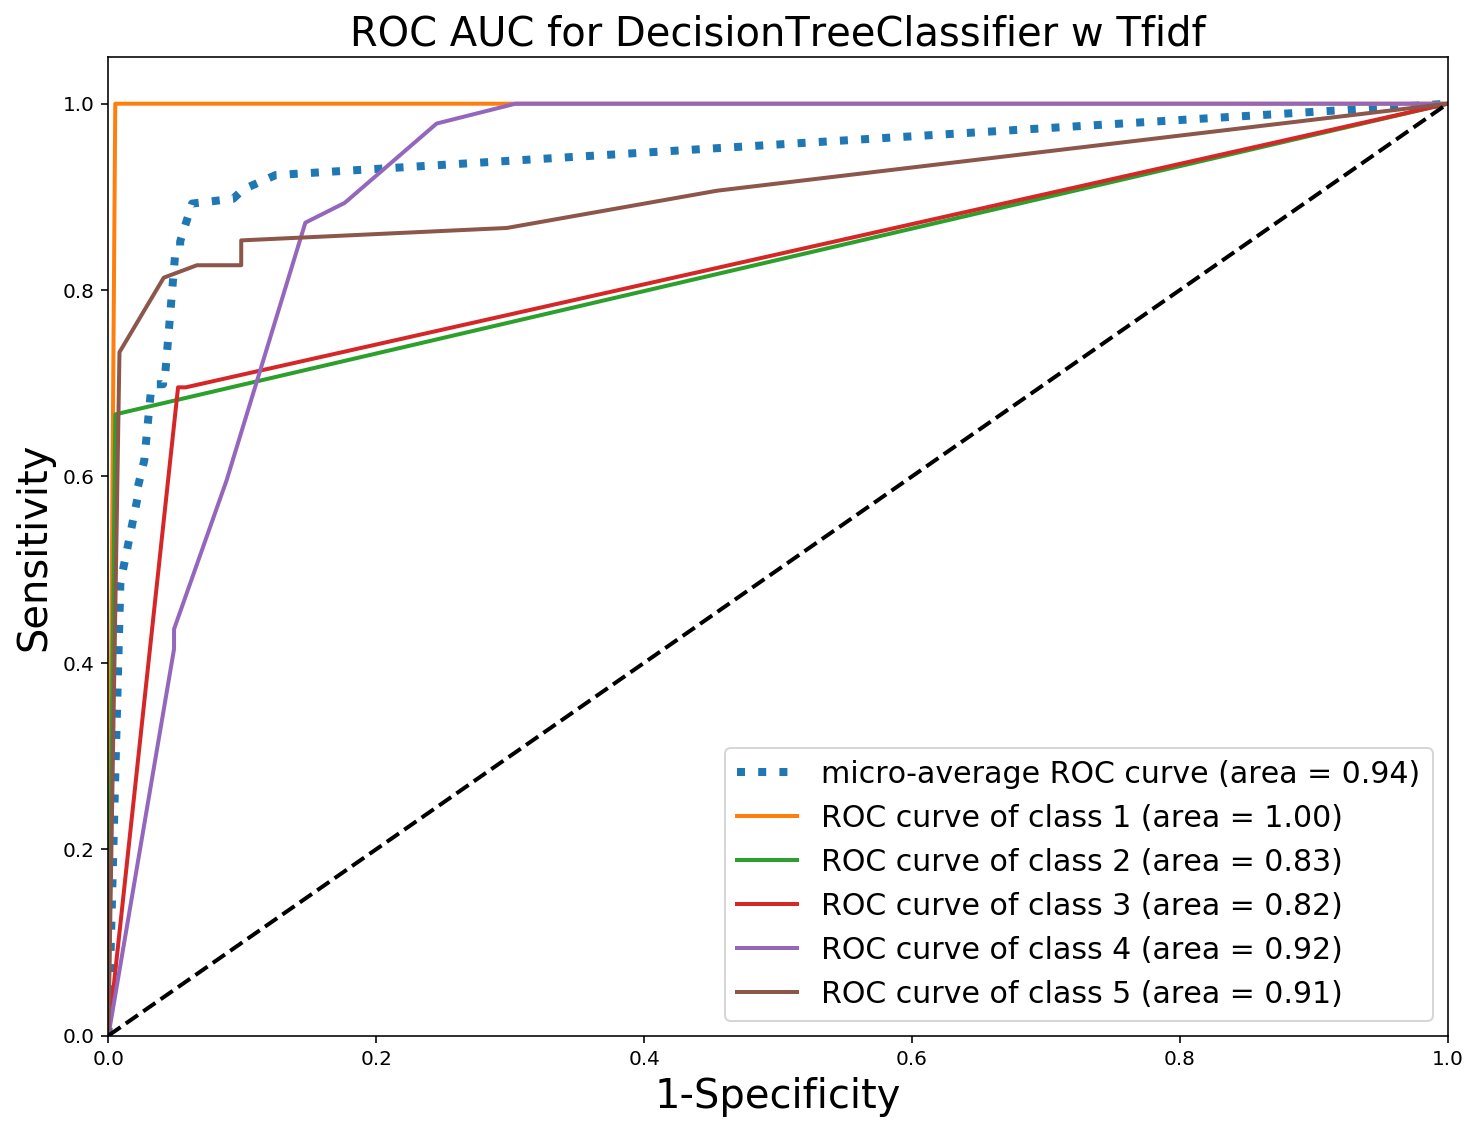

In [33]:
#making a copy of X_legit and y for computation and plotting of ROC AUC for the respective rating classes and micro-average
X_copy = X_legit.copy()

y_copy = y.copy()

# Binarize the output
y_copy = label_binarize(y_copy, classes=[1.0, 2.0, 3.0, 4.0, 5.0])
n_classes = y_copy.shape[1]

# shuffle and split training and test sets
X_copy_train, X_copy_test, y_copy_train, y_copy_test = train_test_split(X_copy, y_copy, test_size=0.2,
                                                    random_state=42, stratify=y_copy)

#instantiate scaler since not all of the features are of the same scale, eg. review_count and avg_store_rating
ss1 = StandardScaler()

#fitting the train and transforming both the train and test sets
X_copy_train_sc = ss1.fit_transform(X_copy_train)
X_copy_test_sc = ss1.transform(X_copy_test)

# Learn to predict each class against the other using the params of tuned model with random_state set to 42 so that the values and curves do not waver
classifier = OneVsRestClassifier(DecisionTreeClassifier(class_weight='balanced',max_depth=7,min_samples_leaf=4,min_samples_split=15, random_state=42))
y_score = classifier.fit(X_copy_train_sc, y_copy_train).predict_proba(X_copy_test_sc)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_copy_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_copy_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves and micro-averaged one
plt.figure(figsize=(12,9))
lw=2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]), linestyle=':', linewidth=4)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity',fontsize=20)
plt.ylabel('Sensitivity',fontsize=20)
plt.title('ROC AUC for DecisionTreeClassifier w Tfidf',fontsize=20)
plt.legend(loc="lower right",fontsize=15)
plt.show()

In [34]:
#calculating one-vs-one and one-vs-rest micro-averaged ROC AUC to check if there is a difference between both
y_prob = classifier.predict_proba(X_copy_test_sc)
micro_roc_auc_ovo = roc_auc_score(y_copy_test, y_prob, multi_class="ovo",
                                     average="micro")
micro_roc_auc_ovr = roc_auc_score(y_copy_test, y_prob, multi_class="ovr",
                                     average="micro")
print("One-vs-One ROC AUC score:\n{:.6f} "
      "(micro-averaged)"
      .format(micro_roc_auc_ovo))
print("One-vs-Rest ROC AUC score:\n{:.6f} "
      "(micro-averaged)"
      .format(micro_roc_auc_ovr))

One-vs-One ROC AUC score:
0.937425 (micro-averaged)
One-vs-Rest ROC AUC score:
0.937425 (micro-averaged)


In [35]:
#calculating one-vs-one and one-vs-rest ROC AUC weighted by prevalence to check if there is a difference between both
y_prob = classifier.predict_proba(X_copy_test_sc)
weighted_roc_auc_ovo = roc_auc_score(y_copy_test, y_prob, multi_class="ovo",
                                     average="weighted")
weighted_roc_auc_ovr = roc_auc_score(y_copy_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC score:\n{:.6f} "
      "(weighted by prevalence)"
      .format(weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC score:\n{:.6f} "
      "(weighted by prevalence)"
      .format(weighted_roc_auc_ovr))

One-vs-One ROC AUC score:
0.901147 (weighted by prevalence)
One-vs-Rest ROC AUC score:
0.901147 (weighted by prevalence)


## Model Summary and Result Interpretation
---

<ul>
    
- Tuned DecisionTreeClassifier performed slightly better than LogReg in terms of micro-averaged precision and recall scores (both 0.85, which translates into a micro-averaged $F_1$ score of 0.85 vs LogReg's 0.81), and it is able to predict all rating classes rather well as evidenced by the multi-class ROC AUC plots and scores.
- This DecisionTreeClassifier was also able to predict all ratings 1 and 2 however scant they are in the test set!
- Accuracy of 0.85, Micro-Averaged precision of 0.85, Micro-Averaged recall of 0.85, Micro-Averaged $F_1$ of 0.85
- Micro-Averaged ROC AUC of 0.94, weighted by prevalence ROC AUC of 0.90, both are higher than tuned LogReg with tfidf and no PCA.